In [153]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib import cm
from matplotlib.tri import Triangulation

import ast

In [154]:
def parse_results(file_name):
    grid_search_results = []
    with open(file_name, 'r') as file:
        for line in file.readlines():
            if line[0:4] == '----':
                grid_search_results.append([])
                continue

            if line[0] == '(':
                fixed_line = '[' + line.strip().replace(') (', '), (') + ']'
                params = ast.literal_eval(fixed_line)
                nested = [list(zip(key.split(','), np.array(val).flatten())) for (key, val) in params]
                unnested = [item for sublist in nested for item in sublist]
                grid_search_results[-1].append({key: val for (key, val) in unnested})
                grid_search_results[-1].append([])
                continue

            result = line

            if result[0] == '[':
                grid_search_results[-1][-1].append(ast.literal_eval(result))
                continue

    grid_search_results = [(params, np.array(values)) for params, values in grid_search_results]
    return grid_search_results

In [155]:
# fracs_mnum = 3200
# seeds_mnum = 320

In [171]:
both_res = parse_results('grid_search_results/both_all_init_300.txt')
hyp_res = both_res[:len(both_res)//2]
euc_res = both_res[len(both_res)//2:]
# hyp_res = both_res
# euc_res = both_res

# both_res = parse_results('grid_search_results/subsets_both_5-seeds_20.txt')
# frac1 = both_res[fracs_mnum*0:fracs_mnum*1]
# frac2 = both_res[fracs_mnum*1:fracs_mnum*2]
# frac3 = both_res[fracs_mnum*2:fracs_mnum*3]
# frac4 = both_res[fracs_mnum*3:fracs_mnum*4]
# frac6 = both_res[fracs_mnum*4:fracs_mnum*5]
# frac8 = both_res[fracs_mnum*5:fracs_mnum*6]
# frac = frac8
# hyp_res = frac
# euc_res = frac

In [172]:
hyp_params = np.array([p for p, _ in hyp_res])
hyp_values = np.array([v for _, v in hyp_res])

euc_params = np.array([p for p, _ in euc_res])
euc_values = np.array([v for _, v in euc_res])

# fix for fracs with multiple seeds
# hyp_params = hyp_params[[i for i in list(range(fracs_mnum)) if not (i//seeds_mnum)%2]]
# hyp_values = hyp_values[[i for i in list(range(fracs_mnum)) if not (i//seeds_mnum)%2]]

# euc_params = euc_params[[i for i in list(range(fracs_mnum)) if (i//seeds_mnum)%2]]
# euc_values = euc_values[[i for i in list(range(fracs_mnum)) if (i//seeds_mnum)%2]]

hyp_values.shape, euc_values.shape

((288, 5, 300), (288, 5, 300))

In [173]:
# hyp_params = hyp_params.reshape([5,seeds_mnum])[0]
# hyp_values = hyp_values.reshape([5,seeds_mnum,5,20]).mean(axis=0)

# euc_params = euc_params.reshape([5,seeds_mnum])[0]
# euc_values = euc_values.reshape([5,seeds_mnum,5,20]).mean(axis=0)

# hyp_values.shape, euc_values.shape

In [174]:
NUM_HIDDEN_LAYERS = sorted(list(set([p['num_hidden_layers'] for p in hyp_params]).union(set([p['num_hidden_layers'] for p in euc_params]))))
LAYER_SIZE = sorted(list(set([p['layer_size'] for p in hyp_params]).union(set([p['layer_size'] for p in euc_params]))))
LR = sorted(list(set([p['lr'] for p in hyp_params]).union(set([p['lr'] for p in euc_params]))))
WD = sorted(list(set([p['weight_decay'] for p in hyp_params]).union(set([p['weight_decay'] for p in euc_params]))))

In [175]:
print(NUM_HIDDEN_LAYERS)
print(LAYER_SIZE)
print(LR)
print(WD)

[1, 2, 4, 8]
[2, 4, 8, 16, 32, 64, 128, 256]
[0.005, 0.01, 0.02]
[0.005, 0.01, 0.02]


In [176]:
num_hidden_layers = np.array(NUM_HIDDEN_LAYERS).repeat(len(LAYER_SIZE))
layer_size = np.tile(LAYER_SIZE, len(NUM_HIDDEN_LAYERS))

In [177]:
hyp_values[0::len(WD)].mean(axis=1)[:,-1].reshape(-1,len(LR))[:,0].shape

(32,)

In [178]:
num_hidden_layers.shape, layer_size.shape

((32,), (32,))

--------------- Weight Decay: 0.005 ---------------


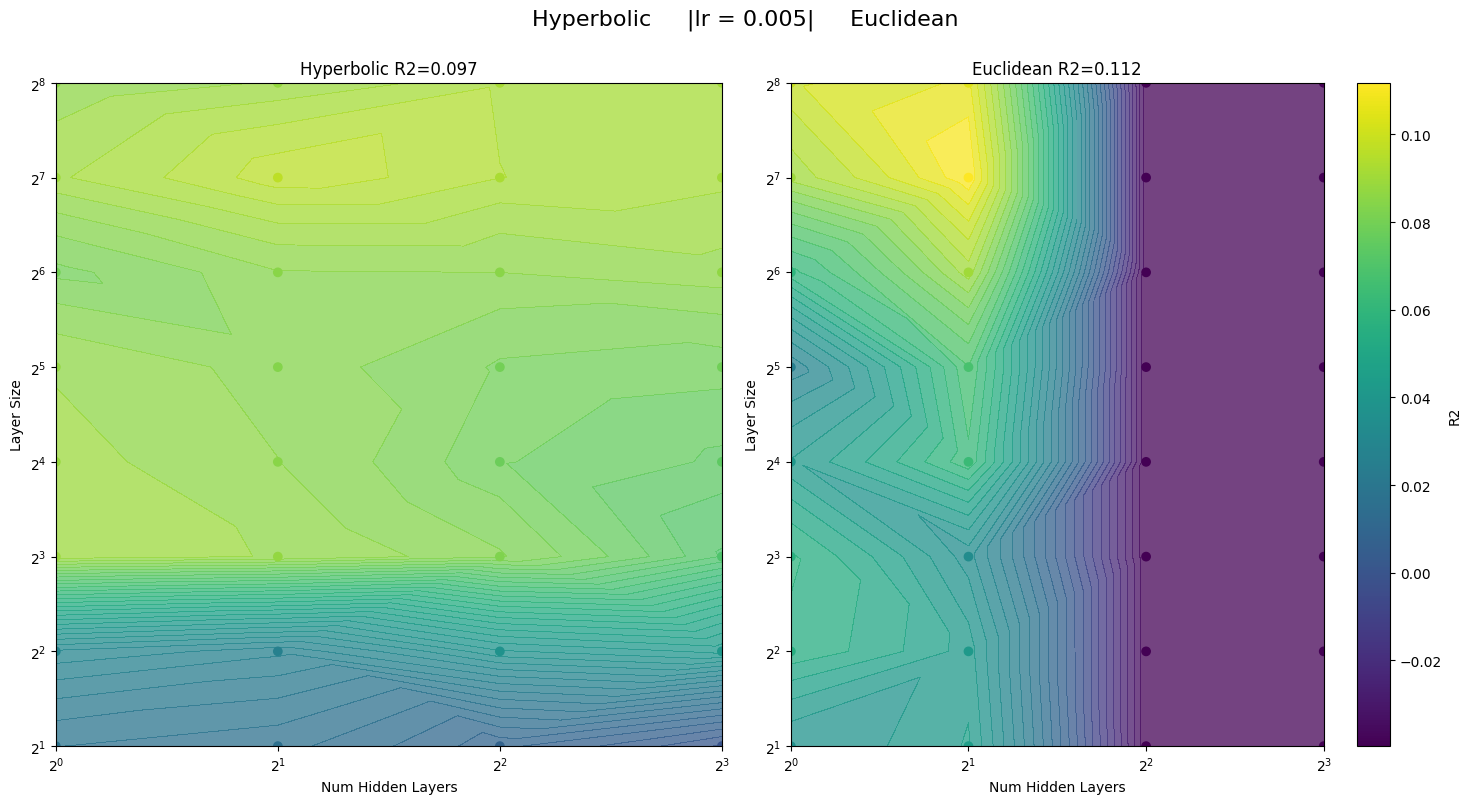

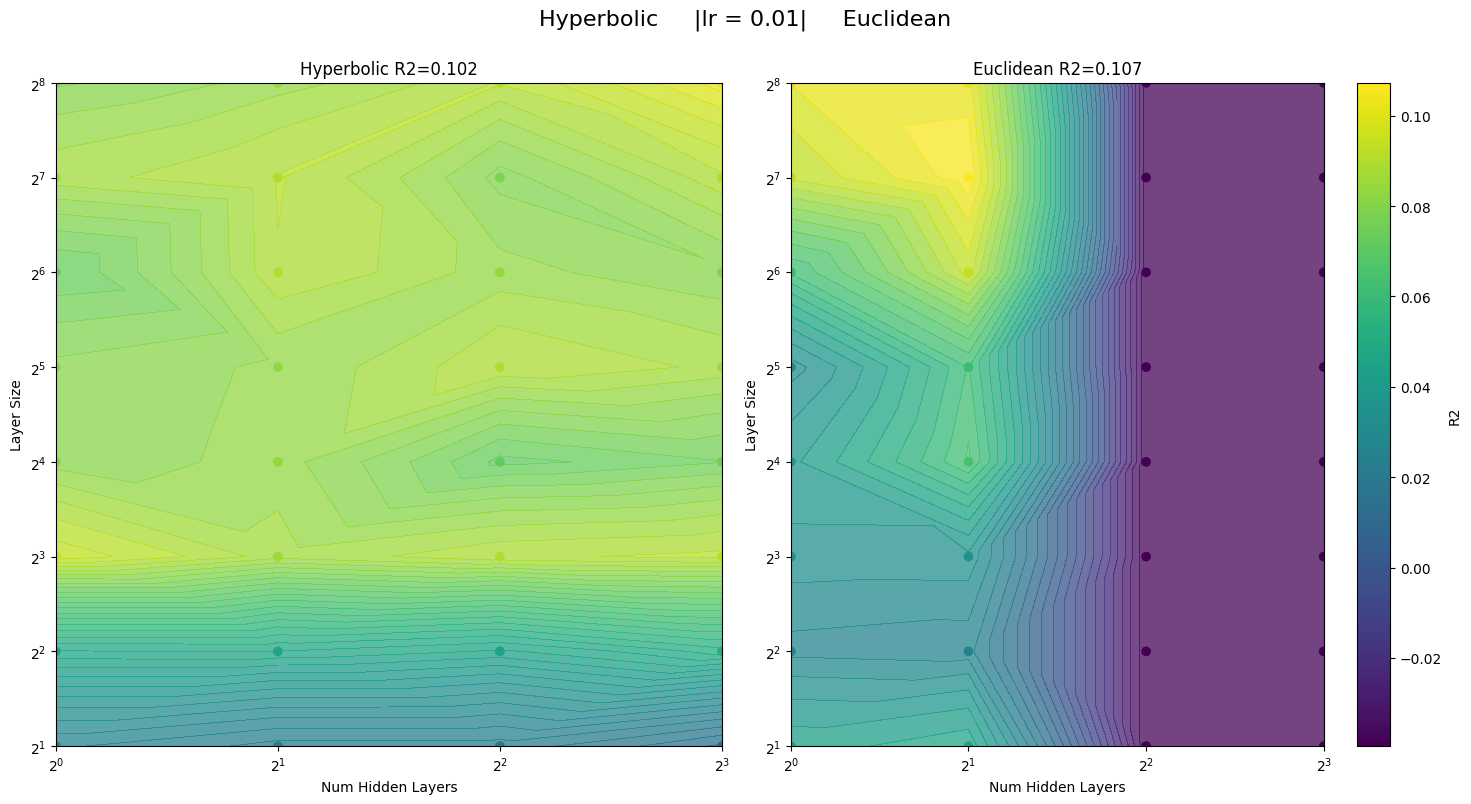

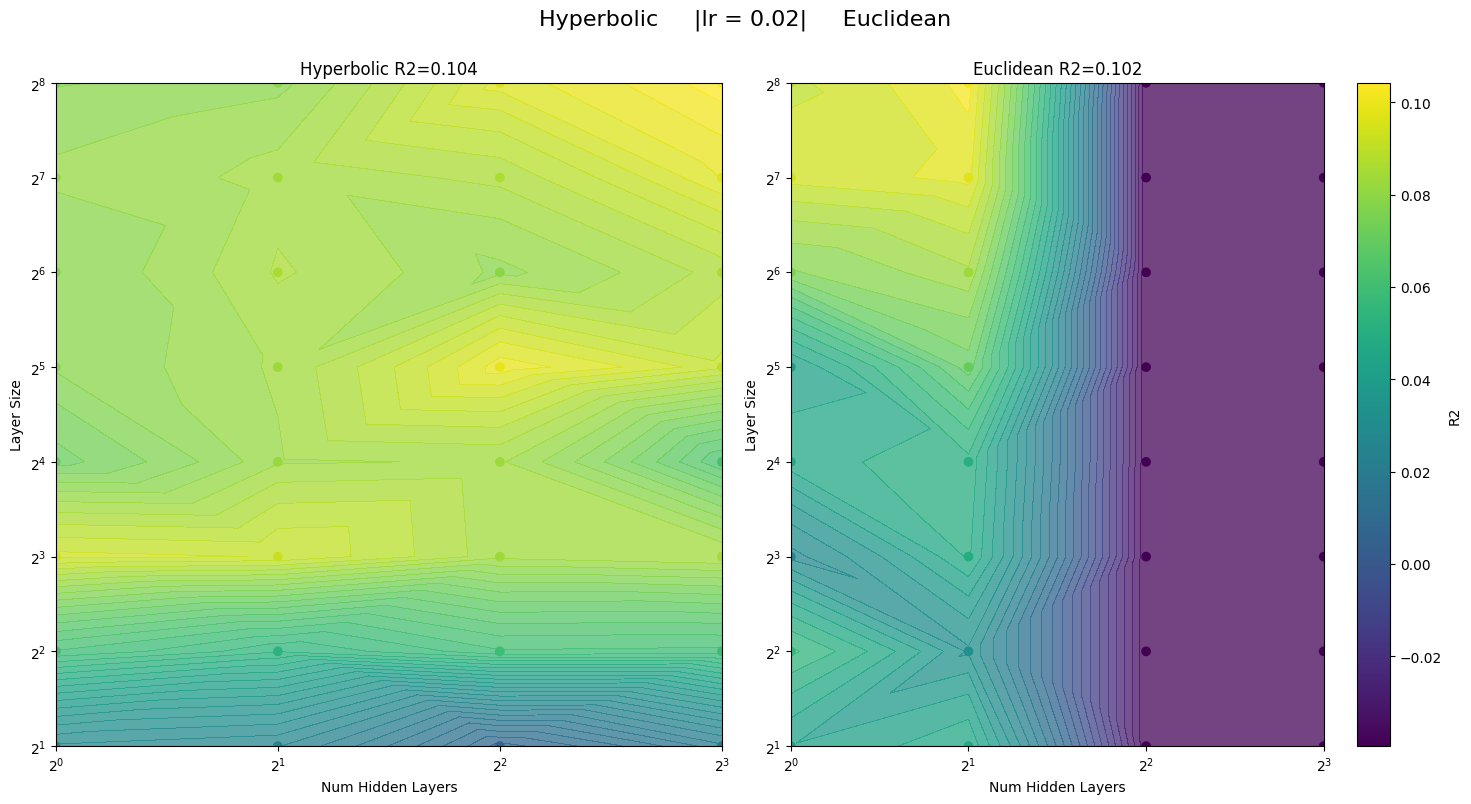

--------------- Weight Decay: 0.01 ---------------


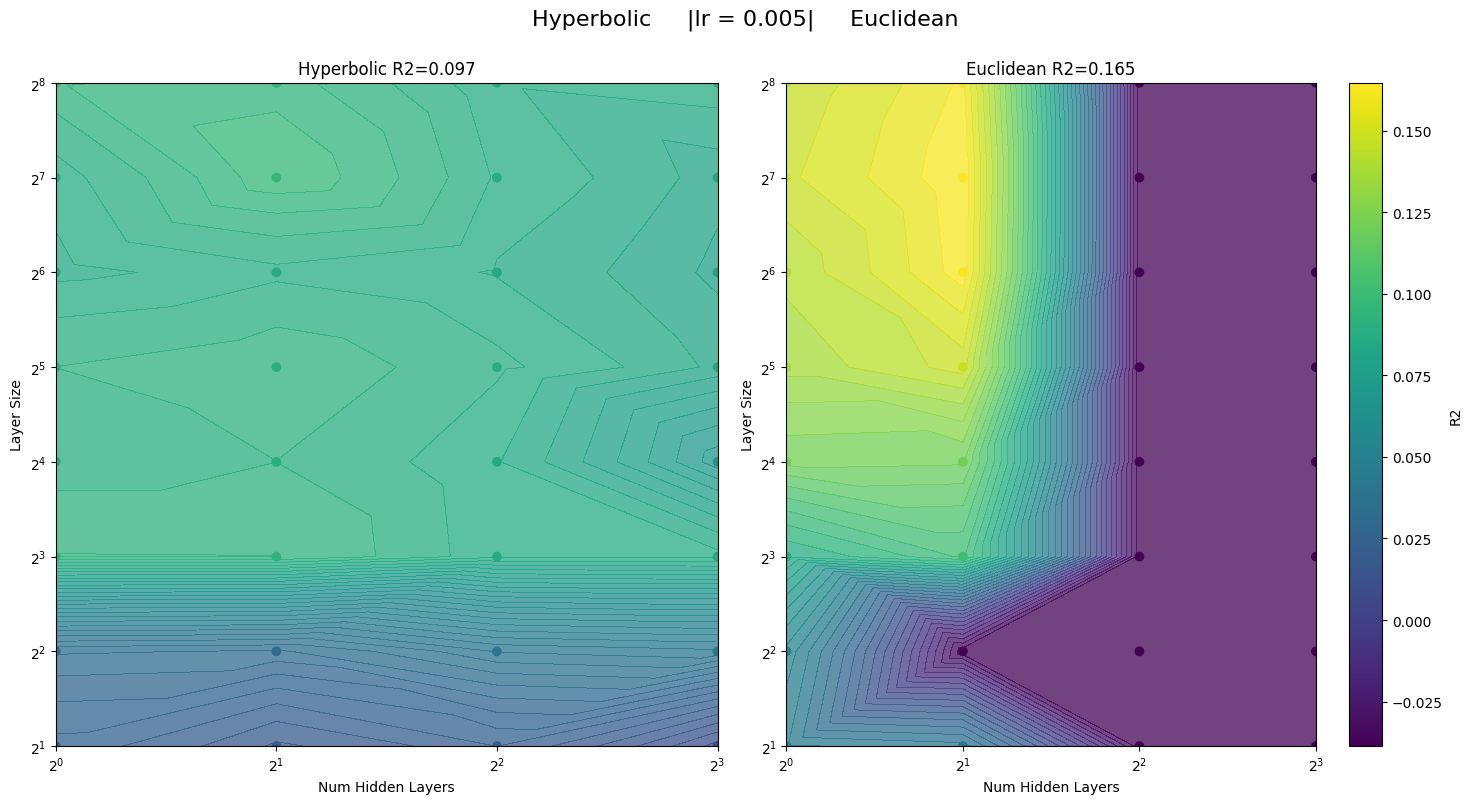

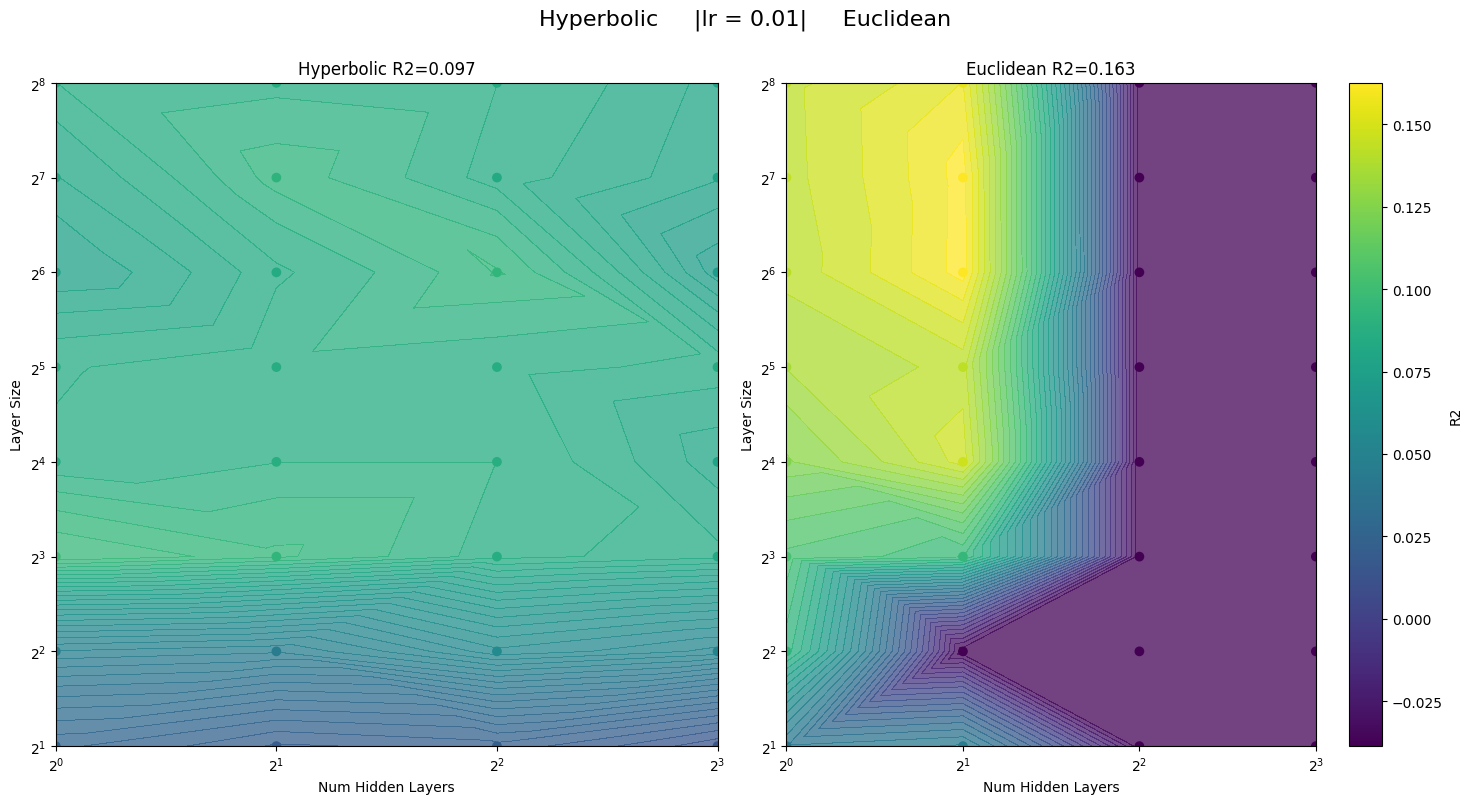

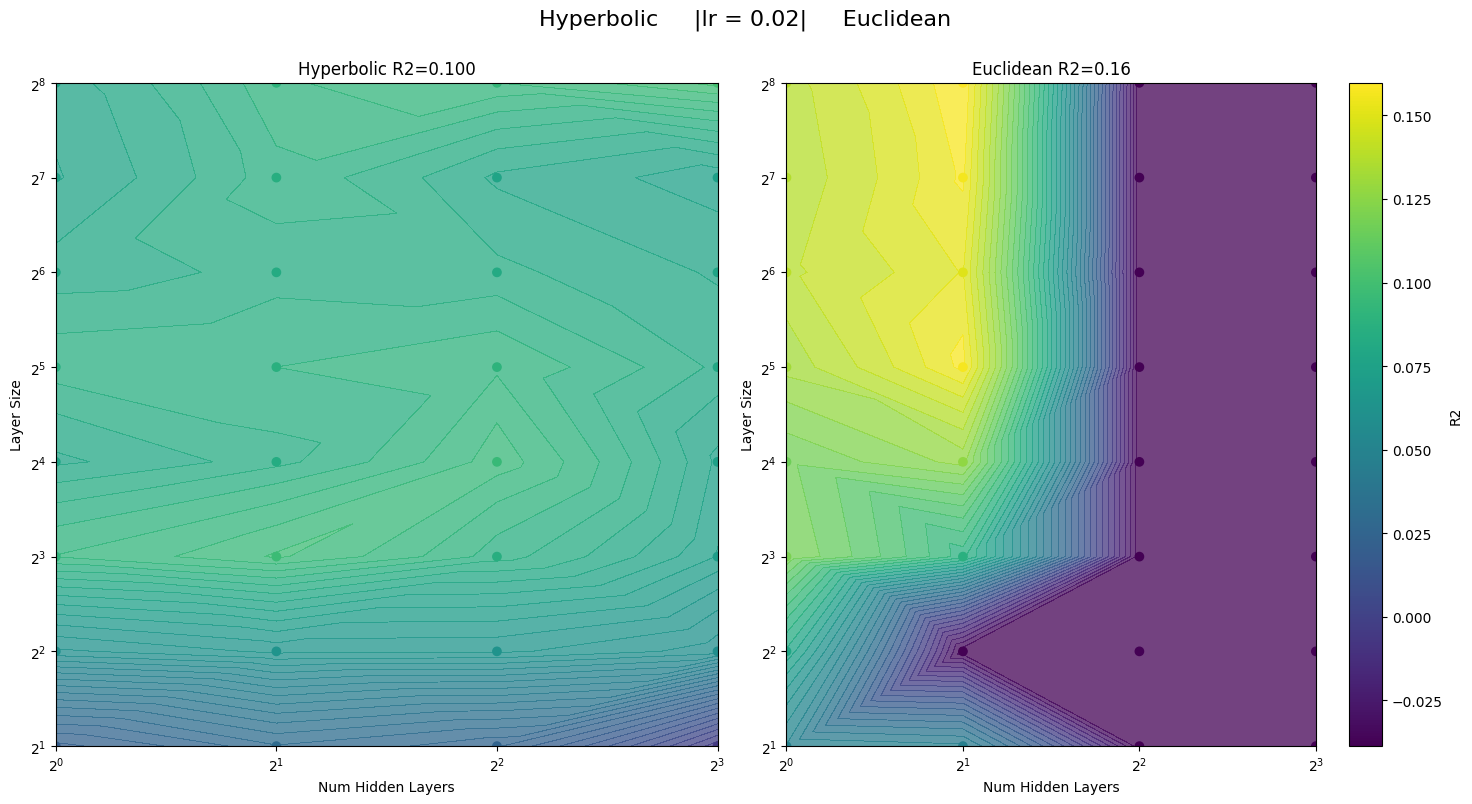

--------------- Weight Decay: 0.02 ---------------


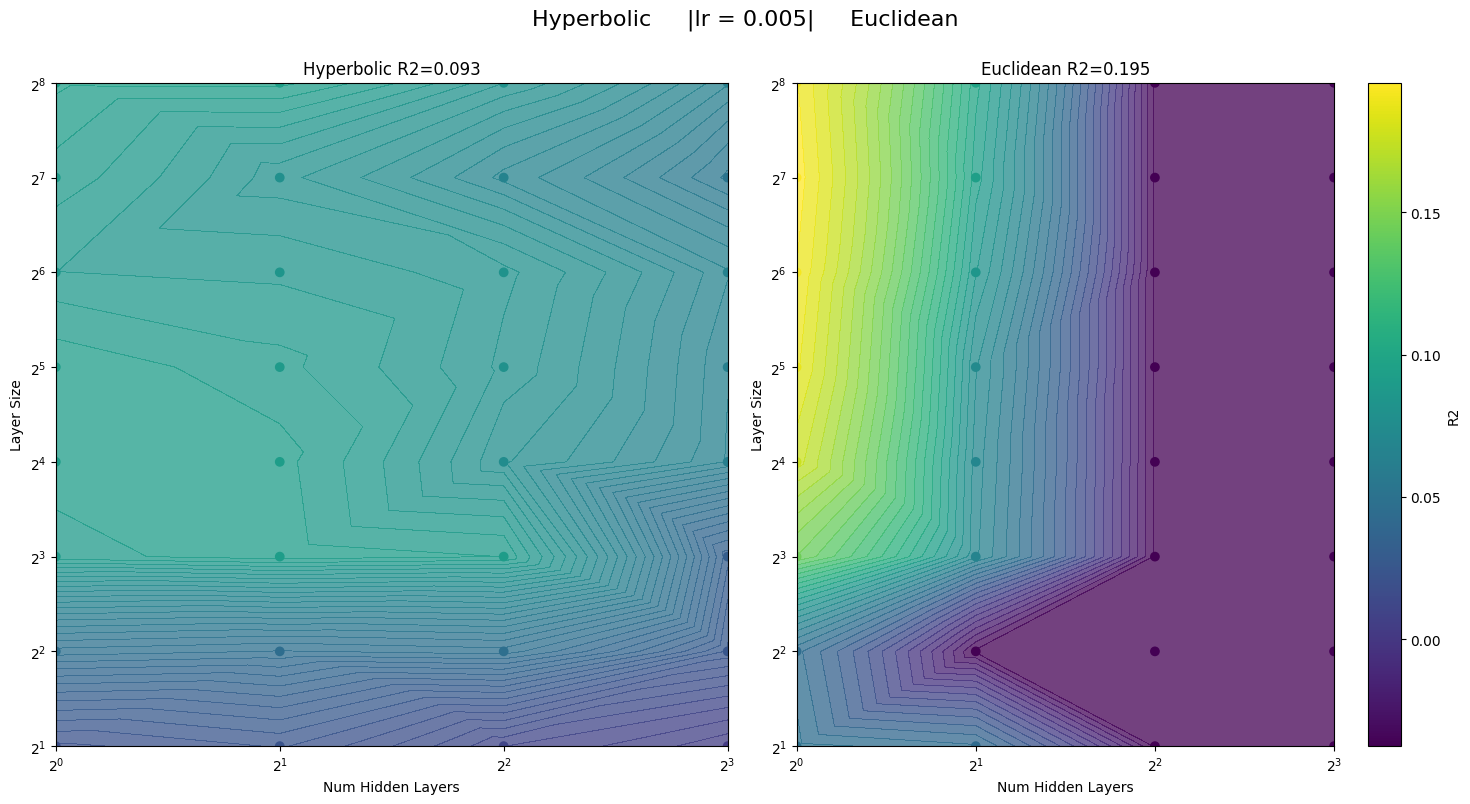

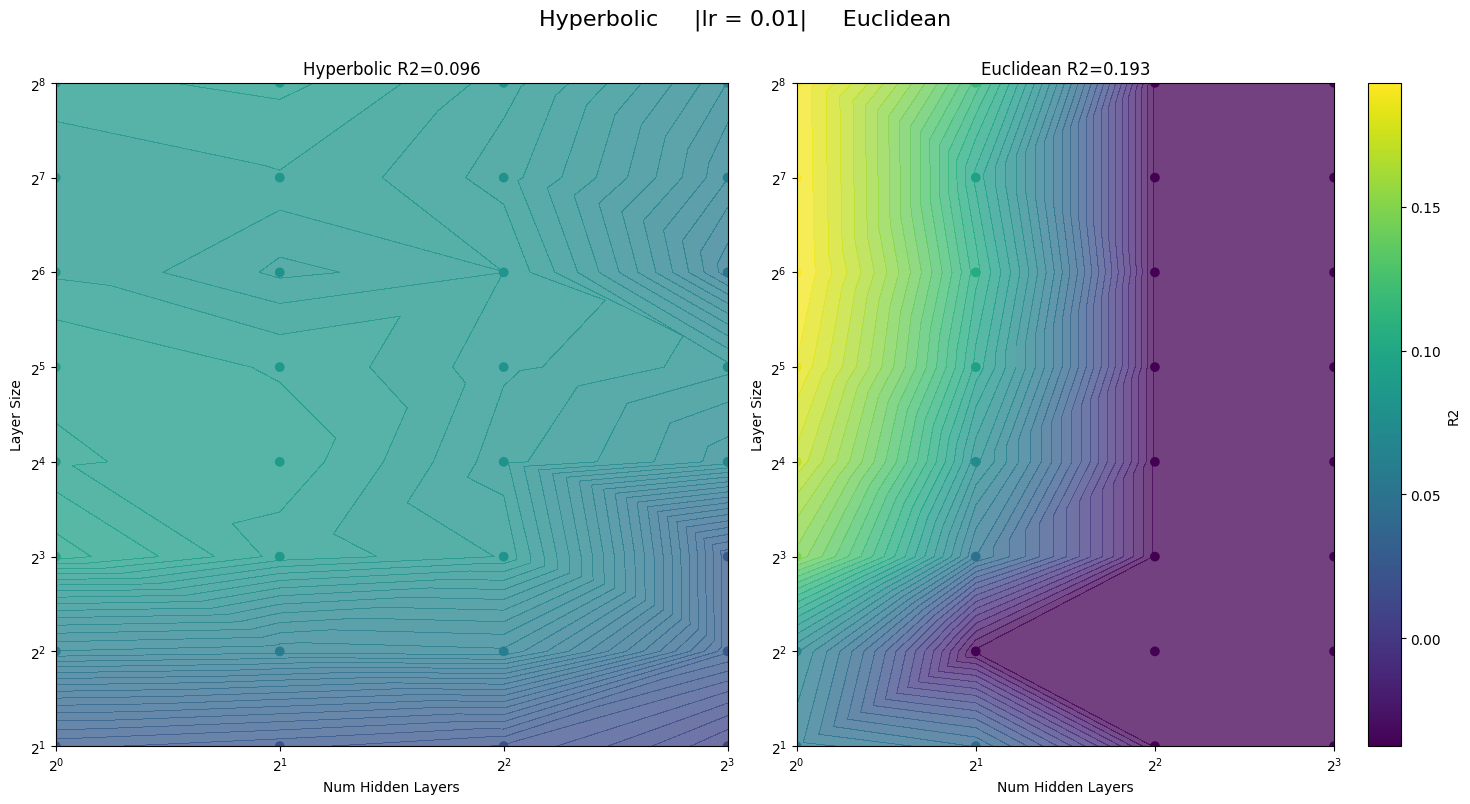

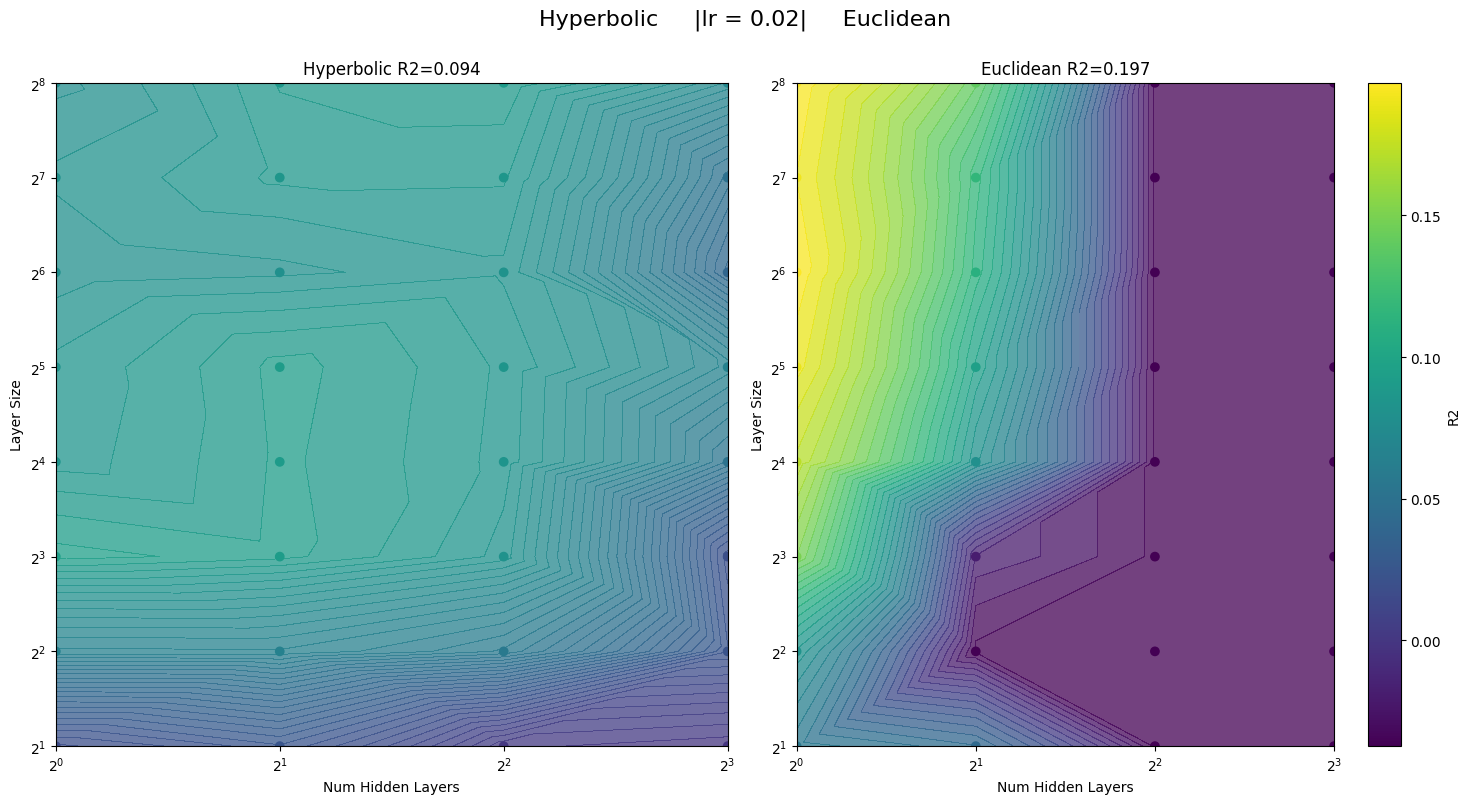

In [179]:
for i, wd in enumerate(WD):
    print(f'--------------- Weight Decay: {wd} ---------------')
    hyp_values_wd = hyp_values[i::len(WD)]
    euc_values_wd = euc_values[i::len(WD)]
    for i, lr in enumerate(LR):
        hyp_data = hyp_values_wd.mean(axis=1)[:,-1].reshape(-1,len(LR))[:,i].clip(-0.1)
        euc_data = euc_values_wd.mean(axis=1)[:,-1].reshape(-1,len(LR))[:,i].clip(-0.1)

        min_val = min(np.min(hyp_data), np.min(euc_data))
        max_val = max(np.max(hyp_data), np.max(euc_data))

        cmap = plt.cm.viridis
        norm = Normalize(vmin=min_val, vmax=max_val)


        num_hidden_layers_adjust = num_hidden_layers.astype(float)
        num_hidden_layers_adjust[num_hidden_layers_adjust == 0] = 0.5

        mesh = Triangulation(num_hidden_layers_adjust, layer_size)  #create tri mesh


        plt.figure(figsize=(15,8))
        plt.suptitle(f'Hyperbolic     |lr = {lr}|     Euclidean', fontsize=16, y=1)

        plt.subplot(121)
        plt.tricontourf(mesh, hyp_data, levels=40, cmap=cmap, norm=norm, alpha=0.75)
        plt.scatter(num_hidden_layers_adjust, layer_size, c=hyp_data, cmap=cmap, norm=norm)

        plt.title(f'Hyperbolic R2={np.max(hyp_data):.3f}')
        plt.xlabel('Num Hidden Layers')
        plt.ylabel('Layer Size')

        plt.xscale('log', base=2)
        plt.yscale('log', base=2)


        plt.subplot(122)
        euc_contourf = plt.tricontourf(mesh, euc_data, levels=40, cmap=cmap, norm=norm, alpha=0.75)
        euc_scatter = plt.scatter(num_hidden_layers_adjust, layer_size, c=euc_data, cmap=cmap, norm=norm)
        plt.colorbar(euc_scatter, label='R2')


        plt.title(f'Euclidean R2={np.max(euc_data):.3}')
        plt.xlabel('Num Hidden Layers')
        plt.ylabel('Layer Size')

        plt.xscale('log', base=2)
        plt.yscale('log', base=2)

        plt.tight_layout()
        plt.show()

<h3>ALL</h3>

- Hyp: 0.116
- Euc: 0.185

<h3>BOTH</h3>

- Hyp: 0.120
- Euc: 0.139

<h3>AROMA</h3>

- Hyp: 0.099
- Euc: 0.100

<h3>FLAVOUR</h3>

- Hyp: 0.157
- Euc: 0.159

<h3>overall</h3>

- Hyp: 0.057
- Euc: 0.105


<h2>Take subsets of normal cross-val train-indices, average over 5 seeds</h2>
<!-- <h3>Hyp take epoch [1], Euc take epoch [4].</h3> -->
 
<h3>1</h3>

- Hyp: 0.066; 8,16; 0.03,0.04 (1)
- Euc: 0.124; 2,2; 0.02,0.02 (4)

<h3>1/2</h3>

- Hyp: 0.048; 1,128; 0.01,0.04 (0)
- Euc: 0.066; 1,64; 0.01,0.005 (1)

<h3>1/3</h3>

- Hyp: 0.035; 2,64; 0.01,0.01 (0)
- Euc: 0.050; 1,16; 0.01,0.01 (1)

<h3>1/4</h3>

- Hyp: 0.022; 1,128; 0.01,0.04 (0)
- Euc: 0.050, 1,16; 0.01,0.04 (2)

<h3>1/6</h3>

- Hyp: 0.009; 1,128; 0.01,0.04 (0)
- Euc: 0.023; 4,16; 0.02,0.01 (4)

<h3>1/8</h3>

- Hyp: 0.000; 1,128; 0.01,0.04 (0)
- Euc: 0.020; 4,16; 0.02,0.01 (4)

In [180]:
print(hyp_values.mean(axis=1).max(axis=0).argsort()[-288//5:].mean())
print(euc_values.mean(axis=1).max(axis=0).argsort()[-288//5:].mean())

59.43103448275862
173.63793103448276


In [181]:
print(hyp_values.mean(axis=1).max(axis=0).argsort())
print(hyp_values.max(axis=1).max(axis=0).argsort())
print(euc_values.mean(axis=1).max(axis=0).argsort())
print(euc_values.max(axis=1).max(axis=0).argsort())

[  0   1   2   3   4   5 280 290 283 298 294 284 289 277 297 286 287 263
 299 222 270 254   6 179 257 243 295 293 291 288 276 187 279 262 285 183
 274 273 230 271 266 246 252   7 240 296 199 251 173 259 260   8 190 267
 239 176 282 249 211 161 269 248 265 226 182 245 228 186 256 214 216 219
 233 268 292 242 258 217 232 213 224 231 247 192 207 235 193 206 281 148
 278 165 237 264 275 238 196 203 210   9 170 164 209 225 152 215 204 197
 175 145 236 255 202 227 169 221 229 261 112 171 189 178 250 155 234 272
 218 105 181 167 141 133 223 149 137 253 174 163 157 159 200 151  10 162
 143 191 201 241 195 138 156 220 188 244 184 168 198 135 119 166 205 146
  11  14 212  13 208 160 194 116 122  12 124 132 158 172  94 140 108 180
 153 150 136 127 142 154 131  77 128 109  15 177 117 144  90  81  98 113
 125 130 129 101 118 134 147 115 121  22 123  86 111  70  61  58  20 106
  97  16 185  24  74  23 139 102  73 114  80  25 126  18  19 103  67  76
  17  91  21 120  66 110  65  85 100  55  56  89  5

In [182]:
K_HYP = 60
K_EUC = 170
reduce = np.mean


best_hyp_params = list(reversed(np.argsort(reduce(hyp_values, axis=1)[:,K_HYP])[-9:]))
print(reduce(hyp_values, axis=1)[:,K_HYP][best_hyp_params])
print()
best_euc_params = list(reversed(np.argsort(reduce(euc_values, axis=1)[:,K_EUC])[-9:]))
print(reduce(euc_values, axis=1)[:,K_EUC][best_euc_params])

best_hyp_runs = reduce(hyp_values, axis=1)[best_hyp_params]
best_euc_runs = reduce(euc_values, axis=1)[best_euc_params]

[0.1180164  0.11261791 0.11207368 0.1115437  0.10714637 0.10643318
 0.10638762 0.10630449 0.10601118]

[0.19695096 0.19656094 0.19546117 0.19527552 0.19417852 0.19100354
 0.18951847 0.18949601 0.18908776]


In [183]:
print(hyp_params[best_hyp_params])
print()
print(euc_params[best_euc_params])

[{'model_type': 'hyp', 'num_hidden_layers': 4, 'layer_size': 32, 'lr': 0.02, 'weight_decay': 0.005, 'batch_size': 1024, 'epochs': 300, 'curvature': -1}
 {'model_type': 'hyp', 'num_hidden_layers': 8, 'layer_size': 256, 'lr': 0.02, 'weight_decay': 0.005, 'batch_size': 1024, 'epochs': 300, 'curvature': -1}
 {'model_type': 'hyp', 'num_hidden_layers': 1, 'layer_size': 32, 'lr': 0.02, 'weight_decay': 0.005, 'batch_size': 1024, 'epochs': 300, 'curvature': -1}
 {'model_type': 'hyp', 'num_hidden_layers': 2, 'layer_size': 32, 'lr': 0.02, 'weight_decay': 0.005, 'batch_size': 1024, 'epochs': 300, 'curvature': -1}
 {'model_type': 'hyp', 'num_hidden_layers': 1, 'layer_size': 32, 'lr': 0.02, 'weight_decay': 0.01, 'batch_size': 1024, 'epochs': 300, 'curvature': -1}
 {'model_type': 'hyp', 'num_hidden_layers': 1, 'layer_size': 128, 'lr': 0.02, 'weight_decay': 0.005, 'batch_size': 1024, 'epochs': 300, 'curvature': -1}
 {'model_type': 'hyp', 'num_hidden_layers': 2, 'layer_size': 64, 'lr': 0.02, 'weight_de

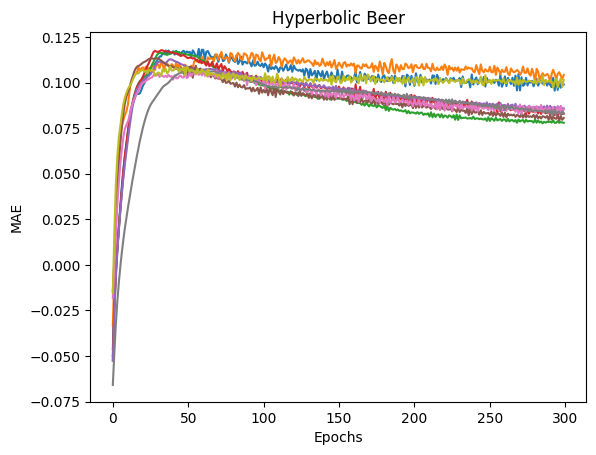

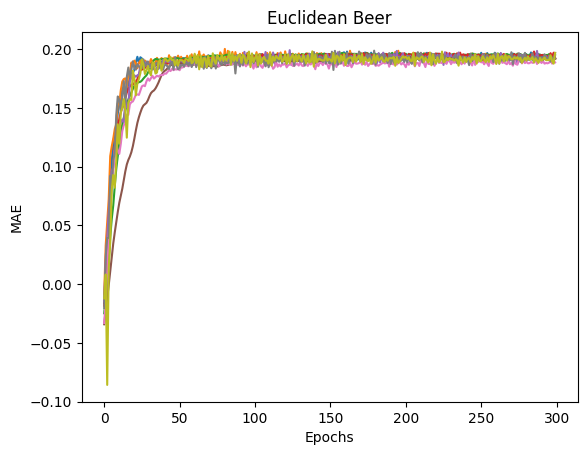

In [184]:
for run in best_hyp_runs:
    plt.plot(run)
    # plt.plot(run[25:])

plt.title('Hyperbolic Beer')
plt.ylabel('MAE')
plt.xlabel('Epochs')

# plt.ylim(0.03,0.07)
# plt.yscale('log')
plt.show()

for run in best_euc_runs:
    plt.plot(run)
    # plt.plot(run[25:])

plt.title('Euclidean Beer')
plt.ylabel('MAE')
plt.xlabel('Epochs')

# plt.ylim(0.03,0.07)
# plt.yscale('log')
plt.show()
